# Imports

In [1]:
import os
import sys
import re
import pandas as pd
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import logging

import fasttext

sns.set_style("darkgrid")

pd.set_option('display.max_columns', 300)
pd.options.display.float_format = '{:20,.2f}'.format


# Data

## Calendar

* property availability with cost and min/max nights  
* 1 year 2019.11.05 to 2020.11.04

In [2]:
calendar = pd.read_csv('data/calendar.csv')
calendar['date'] = pd.to_datetime(calendar['date'])

In [3]:
calendar

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,11551,2019-11-06,f,$105.00,$105.00,3.00,180.00
1,90700,2019-11-06,f,$125.00,$125.00,90.00,"1,125.00"
2,90700,2019-11-07,f,$125.00,$125.00,90.00,"1,125.00"
3,90700,2019-11-08,f,$125.00,$125.00,90.00,"1,125.00"
4,90700,2019-11-09,f,$125.00,$125.00,90.00,"1,125.00"
...,...,...,...,...,...,...,...
31050089,39869282,2020-10-31,t,$169.00,$169.00,19.00,90.00
31050090,39869282,2020-11-01,t,$169.00,$169.00,19.00,90.00
31050091,39869282,2020-11-02,t,$169.00,$169.00,19.00,90.00
31050092,39869282,2020-11-03,t,$169.00,$169.00,19.00,90.00


In [4]:
calendar.info(show_counts=True)

<class 'pandas.DataFrame'>
RangeIndex: 31050094 entries, 0 to 31050093
Data columns (total 7 columns):
 #   Column          Non-Null Count     Dtype         
---  ------          --------------     -----         
 0   listing_id      31050094 non-null  int64         
 1   date            31050094 non-null  datetime64[us]
 2   available       31050094 non-null  str           
 3   price           31049176 non-null  str           
 4   adjusted_price  31049176 non-null  str           
 5   minimum_nights  31050084 non-null  float64       
 6   maximum_nights  31050084 non-null  float64       
dtypes: datetime64[us](1), float64(2), int64(1), str(3)
memory usage: 1.6 GB


In [5]:
calendar.loc[calendar['price'].isna()]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
2293661,4913643,2019-11-06,t,NaN,NaN,2.00,14.00
2293662,4913643,2019-11-07,t,NaN,NaN,2.00,14.00
2293663,4913643,2019-11-08,t,NaN,NaN,2.00,14.00
2293664,4913643,2019-11-09,t,NaN,NaN,2.00,14.00
2293665,4913643,2019-11-10,t,NaN,NaN,2.00,14.00
...,...,...,...,...,...,...,...
18834636,27872336,2020-10-31,f,NaN,NaN,1.00,"1,125.00"
28865990,38520852,2020-11-01,f,NaN,NaN,4.00,"1,125.00"
28865991,38520852,2020-11-02,f,NaN,NaN,4.00,"1,125.00"
28865992,38520852,2020-11-03,f,NaN,NaN,4.00,"1,125.00"


In [6]:
calendar['date'].min(), calendar['date'].max()

(Timestamp('2019-11-05 00:00:00'), Timestamp('2020-11-04 00:00:00'))

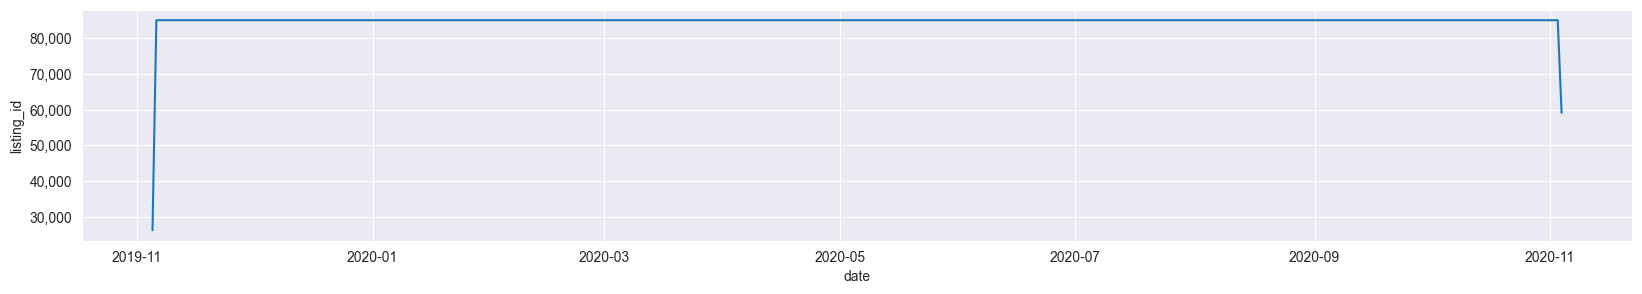

In [7]:
fig, ax = plt.subplots(1,1, figsize=(20,3))

plot_data = calendar.groupby(['date'])['listing_id'].count().reset_index()
sns.lineplot(data=plot_data, x='date', y='listing_id')
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

In [8]:
plot_data

,date,listing_id
0,2019-11-05,26235
1,2019-11-06,85068
2,2019-11-07,85068
3,2019-11-08,85068
4,2019-11-09,85068
...,...,...
361,2020-10-31,85068
362,2020-11-01,85068
363,2020-11-02,85068
364,2020-11-03,85068


In [9]:
calendar['price'].value_counts()

price
$50.00       949237
$100.00      944817
$40.00       900338
$35.00       880909
$30.00       814040
              ...  
$2,090.00         1
$2,068.00         1
$2,904.00         1
$2,323.00         1
$2,403.00         1
Name: count, Length: 2684, dtype: int64

In [10]:
calendar = pd.read_csv('data/calendar.csv')
calendar = calendar.loc[~calendar['date'].isin(['2019-11-05', '2020-11-04'])].reset_index(drop=True) # drop incomplete data for first and last date
calendar['date'] = pd.to_datetime(calendar['date'])
calendar = calendar.dropna(subset='price') # drop price na's, only ~915 rows
calendar['price'] = calendar['price'].str.replace(r'[^\d.]', '', regex=True).astype(float)
calendar['adjusted_price'] = calendar['adjusted_price'].str.replace(r'[^\d.]', '', regex=True).astype(float)

print(f'min date: {calendar['date'].min()}, max date: {calendar['date'].max()}')
print(f'min price: {calendar['price'].min()}, max price: {calendar['price'].max()}')
calendar

min date: 2019-11-06 00:00:00, max date: 2020-11-03 00:00:00
min price: 7.0, max price: 12345.0


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,11551,2019-11-06,f,105.00,105.00,3.00,180.00
1,90700,2019-11-06,f,125.00,125.00,90.00,"1,125.00"
2,90700,2019-11-07,f,125.00,125.00,90.00,"1,125.00"
3,90700,2019-11-08,f,125.00,125.00,90.00,"1,125.00"
4,90700,2019-11-09,f,125.00,125.00,90.00,"1,125.00"
...,...,...,...,...,...,...,...
30964747,39869282,2020-10-30,t,169.00,169.00,19.00,90.00
30964748,39869282,2020-10-31,t,169.00,169.00,19.00,90.00
30964749,39869282,2020-11-01,t,169.00,169.00,19.00,90.00
30964750,39869282,2020-11-02,t,169.00,169.00,19.00,90.00


In [11]:
calendar_price = calendar.loc[(calendar['price'] != calendar['adjusted_price'])]
calendar_price['diff'] = calendar_price['price'] - calendar_price['adjusted_price']
calendar_price['diff_pct'] = round(calendar_price['adjusted_price'] / calendar_price['price'],2)
print(calendar_price['diff_pct'].min(), calendar_price['diff_pct'].max())
calendar_price.sort_values('diff_pct')

# spikes around new years and june/jul (wimbledon) for certain properties indicate that adjusted_price column might represent special event pricing

0.1 6.0


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,diff,diff_pct
7800612,14573307,2019-11-06,f,42.00,4.00,1.00,"1,125.00",38.00,0.10
27868109,37843451,2019-11-07,f,500.00,110.00,1.00,3.00,390.00,0.22
24115607,34456467,2019-11-06,f,178.00,39.00,1.00,3.00,139.00,0.22
24115608,34456467,2019-11-07,f,178.00,39.00,1.00,3.00,139.00,0.22
24116321,34456549,2019-11-06,f,187.00,41.00,1.00,"1,125.00",146.00,0.22
...,...,...,...,...,...,...,...,...,...
30717846,39724118,2019-12-31,t,200.00,"1,200.00",1.00,"1,125.00","-1,000.00",6.00
30587449,39671350,2019-12-31,t,888.00,"5,328.00",1.00,7.00,"-4,440.00",6.00
30719919,39724318,2019-12-31,t,200.00,"1,200.00",1.00,"1,125.00","-1,000.00",6.00
30582307,39670401,2019-12-31,f,300.00,"1,800.00",2.00,"1,125.00","-1,500.00",6.00


<Axes: xlabel='date', ylabel='diff_pct'>

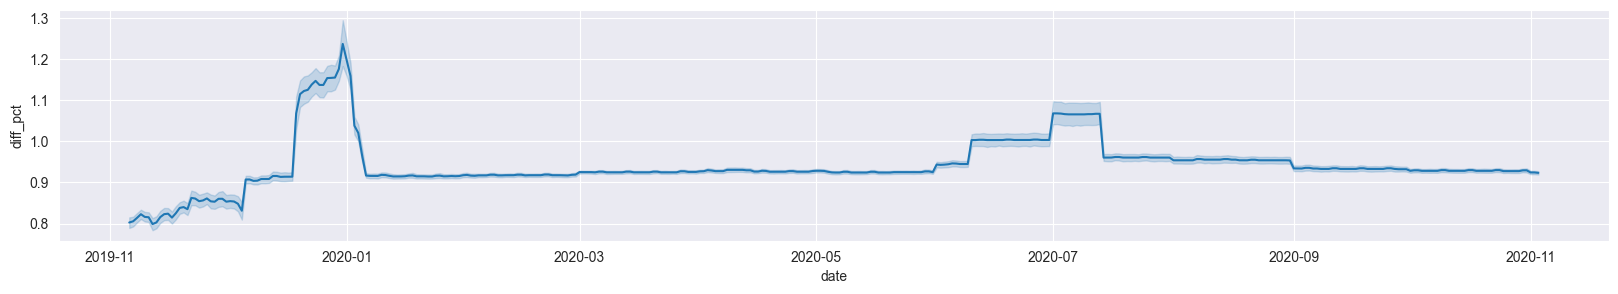

In [12]:
fig, ax = plt.subplots(1,1, figsize=(20,3))

plot_data = calendar_price.copy()
sns.lineplot(data=plot_data, x='date', y='diff_pct', estimator='mean')

## Listings

In [13]:
listings_summary = pd.read_csv('data/listings_summary.csv')
listings = pd.read_csv('data/listings.csv')

/var/folders/qn/f2jdz13n30n9d4ztmqh1htp80000gr/T/ipykernel_91643/2446089131.py:2: DtypeWarning: Columns (0: weekly_price, 1: monthly_price, 2: license, 3: jurisdiction_names) have mixed types. Specify dtype option on import or set low_memory=False.
  listings = pd.read_csv('data/listings.csv')


In [14]:
listings_summary

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,11551,Arty and Bright London Apartment in Zone 2,43039,Adriano,NaN,Lambeth,51.46,-0.12,Entire home/apt,88,3,185,2019-09-15,1.58,2,336
1,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.57,-0.11,Private room,65,1,19,2019-10-07,0.17,2,365
2,90700,Sunny Notting Hill flat & terrace,491286,Chil,NaN,Kensington and Chelsea,51.51,-0.20,Entire home/apt,105,2,339,2019-07-30,3.33,2,268
3,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.49,-0.17,Entire home/apt,100,30,88,2019-09-23,0.73,1,158
4,92399,"MODERN SELF CONTAINED ARCHITECT FLATLET, ISLIN...",497366,Andrea & Mark,NaN,Islington,51.55,-0.09,Private room,77,1,207,2019-10-21,2.04,2,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85063,38398365,Beautiful flat in Central London,24782379,Shabnam,NaN,Lambeth,51.49,-0.13,Entire home/apt,117,3,2,2019-11-04,2.00,1,59
85064,39869123,Elegant stylish modern house with amazing view!,21145791,Ingrid,NaN,Merton,51.41,-0.23,Private room,69,2,0,NaN,NaN,2,113
85065,39869214,Holland Road - Kensington Olympia,251922260,Christian,NaN,Hammersmith and Fulham,51.50,-0.22,Entire home/apt,90,3,0,NaN,NaN,4,63
85066,39869249,Functional single room 18 min to London Bridge,255372486,Nudrat,NaN,Bromley,51.36,0.11,Private room,30,2,0,NaN,NaN,4,1


In [15]:
listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20191105115249,2019-11-06,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,No Smoking (very strict) Check-in time is afte...,Tons of buses (24hrs) go into central London f...,Guest will have access to the entire apartment,No interaction with guests as you book the ent...,No Smoking (very strict) No pets are allowed i...,NaN,NaN,https://a0.muscache.com/im/pictures/1d720898-c...,NaN,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.00,3.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Brixton,Lambeth,NaN,London,NaN,SW9 8DG,London,"London, United Kingdom",GB,United Kingdom,51.46,-0.12,t,Apartment,Entire home/apt,4,1.00,1.00,1.00,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",NaN,$88.00,$645.00,"$2,350.00",$400.00,$30.00,2,$20.00,3,180,3,3,180,180,3.00,180.00,4 days ago,t,17,41,61,336,2019-11-06,185,2,2010-03-21,2019-09-15,92.00,9.00,9.00,10.00,10.00,9.00,9.00,f,NaN,NaN,t,f,strict_14_with_grace_period,f,t,2,2,0,0,1.58
1,38151,https://www.airbnb.com/rooms/38151,20191105115249,2019-11-06,Double room/ lounge,NaN,"Comfortable, large double room /lounge area av...","Comfortable, large double room /lounge area av...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/214176/451...,NaN,163634,https://www.airbnb.com/users/show/163634,Lisa,2010-07-11,GB,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,Crystal Palace,1.00,1.00,['phone'],f,f,"Upper Norwood, Surrey, United Kingdom",LB of Croydon,Croydon,NaN,Upper Norwood,Surrey,SE19 3EJ,London,"Upper Norwood, United Kingdom",GB,United Kingdom,51.42,-0.09,f,Apartment,Private room,2,NaN,1.00,NaN,Real Bed,{},NaN,$65.00,NaN,NaN,NaN,NaN,1,$0.00,1,730,1,1,730,730,1.00,730.00,never,

In [16]:
listings_summary.info(verbose=True, show_counts=True)

<class 'pandas.DataFrame'>
RangeIndex: 85068 entries, 0 to 85067
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              85068 non-null  int64  
 1   name                            85042 non-null  str    
 2   host_id                         85068 non-null  int64  
 3   host_name                       85056 non-null  str    
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   85068 non-null  str    
 6   latitude                        85068 non-null  float64
 7   longitude                       85068 non-null  float64
 8   room_type                       85068 non-null  str    
 9   price                           85068 non-null  int64  
 10  minimum_nights                  85068 non-null  int64  
 11  number_of_reviews               85068 non-null  int64  
 12  last_review                     65062 non-n

In [17]:
summary = pd.DataFrame({
    "dtype": listings.dtypes,
    "non_null_count": listings.count(),
    "null_count": listings.isna().sum(),
    "null_pct": listings.isna().mean() * 100
})

summary[:50]

,dtype,non_null_count,null_count,null_pct
id,int64,85068,0,0.00
listing_url,str,85068,0,0.00
scrape_id,int64,85068,0,0.00
last_scraped,str,85068,0,0.00
name,str,85042,26,0.03
summary,str,80736,4332,5.09
space,str,59218,25850,30.39
description,str,82683,2385,2.80
experiences_offered,str,85068,0,0.00
neighborhood_overview,str,54694,30374,35.71


In [18]:
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'])

print(f'min scraped date: {listings['last_scraped'].min()}, max scraped date: {listings['last_scraped'].max()}')

min scraped date: 2019-11-05 00:00:00, max scraped date: 2019-11-06 00:00:00


### Property / Room

In [19]:
listings.groupby(['property_type'], dropna=False, as_index=False).size().sort_values('size', ascending=False)

,property_type,size
1,Apartment,56265
22,House,17879
13,Condominium,2984
37,Townhouse,2983
34,Serviced apartment,1489
27,Loft,745
3,Bed and breakfast,645
18,Guest suite,366
19,Guesthouse,305
5,Boutique hotel,235


In [20]:
listings.groupby(['room_type'], dropna=False, as_index=False).size().sort_values('size', ascending=False)

,room_type,size
0,Entire home/apt,47445
2,Private room,35882
1,Hotel room,1113
3,Shared room,628


### Price

In [21]:
print(listings['price'].isna().sum())

listings.loc[listings['price'] == 0]

0


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


### Location features

In [22]:
listings['city'].value_counts()

city
Greater London           46869
London                   32410
London                     647
Richmond                   176
Twickenham                 175
                         ...  
Northampton                  1
Kingston Upon Thames         1
Crayford, Dartford           1
Stanwell                     1
Hertfordshire                1
Name: count, Length: 707, dtype: int64

In [23]:
listings['smart_location'].value_counts()

smart_location
Greater London, United Kingdom           46870
London, United Kingdom                   32424
London , United Kingdom                    647
England, United Kingdom                    206
Richmond, United Kingdom                   176
                                         ...  
Northampton , United Kingdom                 1
Kingston Upon Thames , United Kingdom        1
Crayford, Dartford, United Kingdom           1
Stanwell , United Kingdom                    1
Hertfordshire, United Kingdom                1
Name: count, Length: 711, dtype: int64

In [24]:
listings['neighbourhood'].value_counts()

neighbourhood
City of Westminster    5454
LB of Tower Hamlets    4690
LB of Hackney          3815
LB of Islington        3728
LB of Camden           3124
                       ... 
Dulwich Village          20
St. James's              18
Furzedown                17
Beckenham                15
Putney Heath              8
Name: count, Length: 149, dtype: int64

In [25]:
len(listings['neighbourhood_cleansed'].value_counts())

33

### Amenities

In [26]:
listings["amenities"] = listings["amenities"].astype(str)

empty_mask = listings["amenities"].str.strip() == "{}"

n_empty = empty_mask.sum()
pct_empty = n_empty / len(listings) * 100

print(f"Empty amenities rows: {n_empty} ({pct_empty:.2f}%)")

import ast

# Matches either "quoted strings" OR unquoted tokens up to the next comma
_AMENITY_RE = re.compile(r'"([^"]*)"|([^,]+)')

def parse_amenities(s: str) -> list[str]:
    if pd.isna(s):
        return []
    s = str(s).strip()
    if s == "{}":
        return []

    # Remove surrounding braces { ... }
    if s.startswith("{") and s.endswith("}"):
        s = s[1:-1].strip()

    if not s:
        return []

    items = []
    for m in _AMENITY_RE.finditer(s):
        quoted = m.group(1)
        unquoted = m.group(2)

        item = quoted if quoted is not None else unquoted
        item = item.strip()

        # skip blanks that can appear from weird formatting
        if item:
            items.append(item)

    return items

amenities = listings[['amenities']].copy()
amenities["amenities_list"] = amenities["amenities"].apply(parse_amenities)
amenities["n_amenities"] = amenities["amenities_list"].str.len()

print("Empty lists:", (amenities["n_amenities"] == 0).sum())

Empty amenities rows: 340 (0.40%)
Empty lists: 340


In [27]:
amenity_counts = (
    amenities["amenities_list"]
    .explode()                 # one row per amenity
    .value_counts()            # count occurrences
)

print(len(amenity_counts))
print(amenity_counts.head(20))

226
amenities_list
Wifi                         81752
Heating                      80130
Essentials                   79445
Kitchen                      77688
Smoke detector               72997
Washer                       72537
Hangers                      67750
Iron                         65066
Hair dryer                   59404
TV                           58572
Shampoo                      58493
Laptop friendly workspace    53267
Carbon monoxide detector     49829
Hot water                    46421
Dryer                        37537
Refrigerator                 33763
Oven                         30599
Bed linens                   30447
Dishes and silverware        30194
Microwave                    28285
Name: count, dtype: int64


In [28]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
X = mlb.fit_transform(amenities["amenities_list"])

amenities_onehot = pd.DataFrame(X, columns=mlb.classes_, index=amenities.index)
amenities = pd.concat([amenities, amenities_onehot], axis=1)

In [29]:
amenities

,amenities,amenities_list,n_amenities,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,Alfresco bathtub,Amazon Echo,Apple TV,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Balcony,Bath towel,Bathroom essentials,Bathtub,Bathtub with bath chair,Beach essentials,Beach view,Beachfront,Bed linens,Bedroom comforts,Bidet,Body soap,Breakfast,Breakfast bar,Breakfast table,Building staff,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),Ceiling fan,Ceiling fans,Ceiling hoist,Central air conditioning,Changing table,Charcoal barbeque,Chef's kitchen,Children’s books and toys,Children’s dinnerware,Cleaning before checkout,Coffee maker,Convection oven,Cooking basics,Crib,DVD player,Day bed,Dining area,Dining table,Disabled parking spot,Dishes and silverware,Dishwasher,Dog(s),Doorman,Double oven,Dryer,Dual vanity,EV charger,Electric profiling bed,Elevator,En suite bathroom,Espresso machine,Essentials,Ethernet connection,Exercise equipment,Extra pillows and blankets,Extra space around bed,Family/kid friendly,Fax machine,Fire extinguisher,Fire pit,Fireplace guards,Firm mattress,First aid kit,Fixed grab bars for shower,Fixed grab bars for toilet,Flat path to guest entrance,Formal dining area,Free parking on premises,Free street parking,Full kitchen,Game console,Garden,Garden or backyard,Gas fireplace,Gas oven,Ground floor access,Gym,HBO GO,Hair dryer,Hammock,Handheld shower head,Hangers,Heat lamps,Heated floors,Heated towel rack,Heating,High chair,High-resolution computer monitor,Host greets you,Hot tub,Hot water,Hot water kettle,Ice Machine,Indoor fireplace,Internet,Iron,Ironing Board,Jetted tub,Keypad,Kitchen,Kitchenette,Lake access,Laptop friendly workspace,Lock on bedroom door,Lockbox,Long term stays allowed,Lounge area,Luggage dropoff allowed,Media room,Memory foam mattress,Microwave,Mini fridge,Mobile hoist,Mountain view,Mudroom,Murphy bed,Natural gas barbeque,Nespresso machine,Netflix,No stairs or steps to enter,Office,Other,Other pet(s),Outdoor kitchen,Outdoor parking,Outdoor seating,Outlet covers,Oven,Pack ’n Play/travel crib,Paid parking off premises,Paid parking on premises,Parking,Patio or balcony,Pets allowed,Pets live on this property,Piano,Pillow-top mattress,Pocket wifi,Pool,Pool cover,Pool with pool hoist,Printer,Private bathroom,Private entrance,Private gym,Private hot tub,Private living room,Private pool,Projector and screen,Propane barbeque,Rain shower,Refrigerator,Rooftop,Room-darkening shades,Safety card,Satellite TV,Sauna,Security system,Self check-in,Shampoo,Shared gym,Shared hot tub,Shared pool,Shower bathtub combo,Shower chair,Single level home,Ski-in/Ski-out,Smart TV,Smart lock,Smoke detector,Smoking allowed,Soaking tub,Sonos sound system,Sound system,Stair gates,Stand alone bathtub,Stand alone rain shower,Stand alone steam shower,Standing valet,Steam oven,Step-free shower,Stove,Suitable for events,Sun loungers,Surround sound system,TV,Table corner guards,Tennis court,Terrace,Toilet paper,Touchless faucets,Video Games,Walk-in shower,Warming drawer,Washer,Washer / Dryer,Waterfront,Well-lit path to entrance,Wet bar,Wheelchair accessible,"Wide clearance to shower, toilet",Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,Wine cellar,Wine cooler,Wood-burning fireplace,Yoga studio,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...","[TV, Cable TV, Internet, Wifi, Kitchen, Paid p...",22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,

### Descriptive text fields

In [30]:
listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20191105115249,2019-11-06,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,No Smoking (very strict) Check-in time is afte...,Tons of buses (24hrs) go into central London f...,Guest will have access to the entire apartment,No interaction with guests as you book the ent...,No Smoking (very strict) No pets are allowed i...,NaN,NaN,https://a0.muscache.com/im/pictures/1d720898-c...,NaN,43039,https://www.airbnb.com/users/show/43039,Adriano,2009-10-03,"London, England, United Kingdom","Hello, I'm a friendly Italian man with a very ...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/user/47773...,https://a0.muscache.com/im/pictures/user/47773...,Brixton,3.00,3.00,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"London, United Kingdom",Brixton,Lambeth,NaN,London,NaN,SW9 8DG,London,"London, United Kingdom",GB,United Kingdom,51.46,-0.12,t,Apartment,Entire home/apt,4,1.00,1.00,1.00,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",NaN,$88.00,$645.00,"$2,350.00",$400.00,$30.00,2,$20.00,3,180,3,3,180,180,3.00,180.00,4 days ago,t,17,41,61,336,2019-11-06,185,2,2010-03-21,2019-09-15,92.00,9.00,9.00,10.00,10.00,9.00,9.00,f,NaN,NaN,t,f,strict_14_with_grace_period,f,t,2,2,0,0,1.58
1,38151,https://www.airbnb.com/rooms/38151,20191105115249,2019-11-06,Double room/ lounge,NaN,"Comfortable, large double room /lounge area av...","Comfortable, large double room /lounge area av...",none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/214176/451...,NaN,163634,https://www.airbnb.com/users/show/163634,Lisa,2010-07-11,GB,NaN,NaN,NaN,NaN,f,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,Crystal Palace,1.00,1.00,['phone'],f,f,"Upper Norwood, Surrey, United Kingdom",LB of Croydon,Croydon,NaN,Upper Norwood,Surrey,SE19 3EJ,London,"Upper Norwood, United Kingdom",GB,United Kingdom,51.42,-0.09,f,Apartment,Private room,2,NaN,1.00,NaN,Real Bed,{},NaN,$65.00,NaN,NaN,NaN,NaN,1,$0.00,1,730,1,1,730,730,1.00,730.00,never,

### Other features

In [31]:
listings['experiences_offered'].value_counts()

experiences_offered
none        83388
business      582
family        479
social        411
romantic      208
Name: count, dtype: int64

## Neighbourhoods

In [32]:
neighbourhoods = pd.read_csv('data/neighbourhoods.csv')
neighbourhoods_geo = gpd.read_file("data/neighbourhoods.geojson")

In [33]:
neighbourhoods

,neighbourhood_group,neighbourhood
0,NaN,Barking and Dagenham
1,NaN,Barnet
2,NaN,Bexley
3,NaN,Brent
4,NaN,Bromley
5,NaN,Camden
6,NaN,City of London
7,NaN,Croydon
8,NaN,Ealing
9,NaN,Enfield


In [34]:
neighbourhoods_geo

,neighbourhood,neighbourhood_group,geometry
0,Kingston upon Thames,None,"MULTIPOLYGON (((-0.33068 51.32901, -0.33059 51..."
1,Croydon,None,"MULTIPOLYGON (((-0.06402 51.31864, -0.06408 51..."
2,Bromley,None,"MULTIPOLYGON (((0.01213 51.2996, 0.01196 51.29..."
3,Hounslow,None,"MULTIPOLYGON (((-0.24456 51.4887, -0.24468 51...."
4,Ealing,None,"MULTIPOLYGON (((-0.41183 51.53408, -0.41188 51..."
5,Havering,None,"MULTIPOLYGON (((0.15869 51.51219, 0.1587 51.51..."
6,Hillingdon,None,"MULTIPOLYGON (((-0.40407 51.61318, -0.40388 51..."
7,Harrow,None,"MULTIPOLYGON (((-0.40407 51.61318, -0.4032 51...."
8,Brent,None,"MULTIPOLYGON (((-0.19657 51.52765, -0.19685 51..."
9,Barnet,None,"MULTIPOLYGON (((-0.1999 51.67017, -0.1997 51.6..."


In [35]:
#df_neighbourhoods_geo.explore()

## Reviews

In [36]:
reviews_summary = pd.read_csv('data/reviews_summary.csv')
reviews = pd.read_csv('data/reviews.csv')

In [37]:
reviews_summary

,listing_id,date
0,11551,2010-03-21
1,38407,2010-09-22
2,38407,2010-11-02
3,38407,2010-11-09
4,38407,2010-11-13
...,...,...
1486231,39740287,2019-11-03
1486232,39740287,2019-11-04
1486233,22701498,2019-11-03
1486234,38398365,2019-10-21


In [38]:
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and..."
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...
2,90700,337227,2011-06-27,311071,Miqua,it was all in all the perfect week!\r\nchilton...
3,90700,378738,2011-07-17,224367,Prateek,"I'll start with the host, and then move on to ..."
4,90700,543840,2011-09-18,1115024,Jennifer,Great location. Plenty to do just steps outsid...
...,...,...,...,...,...,...
1486231,39740287,559509688,2019-11-04,182032644,Isabel,"A very good stay, I would repeat for sure."
1486232,22701498,558667202,2019-11-03,65955902,Shereen,"Set in a lovely development with onsite bar, c..."
1486233,38398365,552239161,2019-10-21,60436496,Chee Ling,(Website hidden by Airbnb) a.best owner and ge...
1486234,38398365,559541617,2019-11-04,97684167,Carolyn,This flat is perfection! Everything you need i...


In [39]:
reviews.info()

<class 'pandas.DataFrame'>
RangeIndex: 1486236 entries, 0 to 1486235
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype
---  ------         --------------    -----
 0   listing_id     1486236 non-null  int64
 1   id             1486236 non-null  int64
 2   date           1486236 non-null  str  
 3   reviewer_id    1486236 non-null  int64
 4   reviewer_name  1486236 non-null  str  
 5   comments       1485600 non-null  str  
dtypes: int64(3), str(3)
memory usage: 68.0 MB


In [40]:
reviews.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name      0
comments         636
dtype: int64

In [41]:
reviews['date'].min(), reviews['date'].max()

('2009-12-21', '2019-11-06')

In [42]:
reviews['listing_id'].isin(listings['id']).sum()

1486236

In [43]:
reviewers_summary = reviews.groupby(['reviewer_id']).agg({'id': 'count', 'listing_id': 'nunique', 'date': [min, max]}).reset_index()
reviewers_summary.columns = ['reviewer_id', 'n_reviews', 'unique_listings', 'date_min', 'date_max']
reviewers_summary['date_min'] = pd.to_datetime(reviewers_summary['date_min'])
reviewers_summary['date_max'] = pd.to_datetime(reviewers_summary['date_max'])
reviewers_summary.sort_values('n_reviews')

,reviewer_id,n_reviews,unique_listings,date_min,date_max
0,1,1,1,2012-02-15,2012-02-15
803257,102595948,1,1,2018-04-02,2018-04-02
803258,102595955,1,1,2017-06-30,2017-06-30
803259,102596076,1,1,2019-09-06,2019-09-06
803261,102596643,1,1,2018-06-14,2018-06-14
...,...,...,...,...,...
83714,5063588,81,47,2014-03-15,2019-09-26
1010457,166536730,83,10,2018-01-23,2019-11-05
167600,10873276,85,8,2017-10-10,2019-06-07
119147,7222993,94,24,2014-05-24,2019-09-12


In [44]:
# Percent of reviewers with more than 1 review

sum(reviewers_summary['n_reviews'] > 1) / len(reviewers_summary)

0.11875153588434091

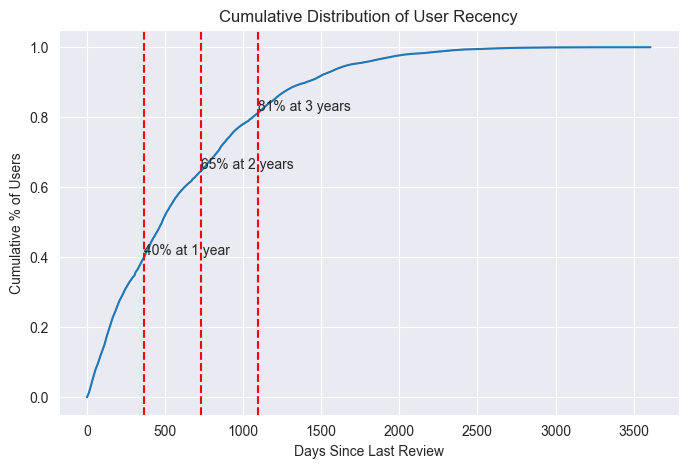

In [45]:
# 60% reviewed within the last two years and 80% within three years

fig, ax = plt.subplots(1,1, figsize=(8,5))

reference_date = reviewers_summary["date_max"].max()
reviewers_summary["days_since_last_review"] = (reference_date - reviewers_summary["date_max"]).dt.days
sorted_days = np.sort(reviewers_summary["days_since_last_review"])
cum_pct = np.arange(1, len(sorted_days)+1) / len(sorted_days)

sns.lineplot(x=sorted_days, y=cum_pct)

one_year, two_years, three_years = 365, 730, 1095
pct_1y = cum_pct[np.searchsorted(sorted_days, one_year)]
pct_2y = cum_pct[np.searchsorted(sorted_days, two_years)]
pct_3y = cum_pct[np.searchsorted(sorted_days, three_years)]
ax.axvline(one_year, linestyle="--", color='red')
ax.axvline(two_years, linestyle="--", color='red')
ax.axvline(three_years, linestyle="--", color='red')
ax.text(one_year, pct_1y, f"{pct_1y:.0%} at 1 year", verticalalignment="bottom")
ax.text(two_years, pct_2y, f"{pct_2y:.0%} at 2 years", verticalalignment="bottom")
ax.text(three_years, pct_3y, f"{pct_3y:.0%} at 3 years", verticalalignment="bottom")

ax.set_xlabel("Days Since Last Review")
ax.set_ylabel("Cumulative % of Users")
ax.set_title("Cumulative Distribution of User Recency")
plt.show()

In [46]:
reviews = reviews.dropna(subset='comments') # drop reviews with no comment
reviews['word_count'] = reviews['comments'].str.split().str.len()
reviews = reviews.loc[reviews['word_count'] > 0]
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,word_count
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and...",49
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...,46
2,90700,337227,2011-06-27,311071,Miqua,it was all in all the perfect week!\r\nchilton...,84
3,90700,378738,2011-07-17,224367,Prateek,"I'll start with the host, and then move on to ...",189
4,90700,543840,2011-09-18,1115024,Jennifer,Great location. Plenty to do just steps outsid...,92
...,...,...,...,...,...,...,...
1486231,39740287,559509688,2019-11-04,182032644,Isabel,"A very good stay, I would repeat for sure.",9
1486232,22701498,558667202,2019-11-03,65955902,Shereen,"Set in a lovely development with onsite bar, c...",24
1486233,38398365,552239161,2019-10-21,60436496,Chee Ling,(Website hidden by Airbnb) a.best owner and ge...,31
1486234,38398365,559541617,2019-11-04,97684167,Carolyn,This flat is perfection! Everything you need i...,54


In [47]:
reviews["word_count"].describe(percentiles=[.1, .5, .75, .9, .95, .99])

count           1,485,597.00
mean                   45.86
std                    46.58
min                     1.00
10%                     7.00
50%                    33.00
75%                    60.00
90%                    97.00
95%                   129.00
99%                   222.00
max                 1,030.00
Name: word_count, dtype: float64

In [48]:
reviews.sort_values('word_count')

,listing_id,id,date,reviewer_id,reviewer_name,comments,word_count
1309662,28754442,443219933,2019-04-25,219840841,Diogo,Great,1
1365600,31265244,464759766,2019-06-06,245463794,雪梅,"没有电梯,4楼(中国的5楼)｡没有照片中的厨房､洗衣机和公共区域｡热水壶是又旧又脏｡淋浴房的...",1
1474572,37834075,536325215,2019-09-26,284964117,Kefa,"房间干净舒适､厨房､卫生间物品齐全,交通便利,房东很好沟通｡",1
958036,19488783,249582564,2018-04-02,147556485,健,Brilliant,1
193821,2173335,11177822,2014-03-24,825815,Leo,Amazing!!,1
...,...,...,...,...,...,...,...
1349027,30247313,486985769,2019-07-13,16606236,Martine,NEDERLANDS/DUTCH Ik ben niet iemand die beoord...,1002
707740,14629530,407511297,2019-02-02,8258215,Salva,I don't like writing bad reviews. And this is ...,1002
847550,17356537,407452650,2019-02-02,6715640,Zoey,0 STAR REVIEW **HORRIBLE** Let me start this b...,1003
1030598,20857286,340593055,2018-10-24,59134685,Rossella,My stay has been horrible since the very first...,1009


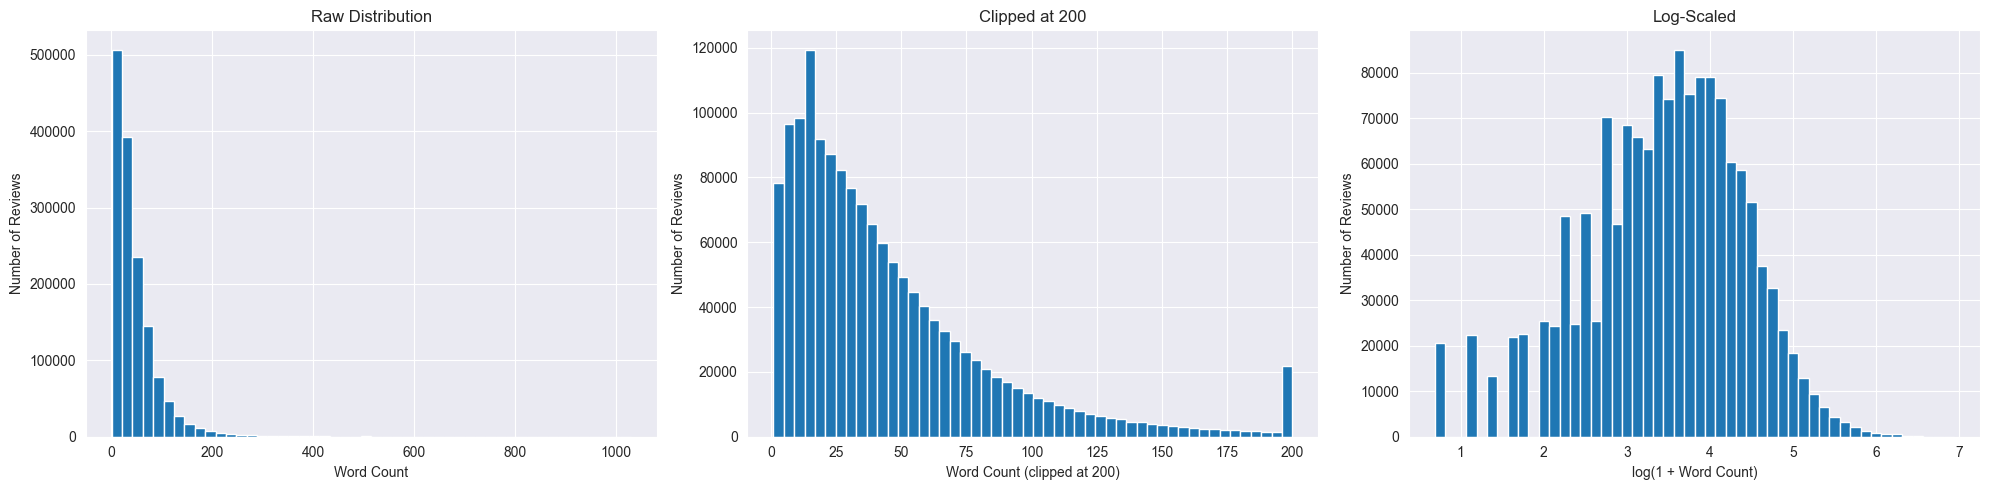

In [49]:
# median review length: 33 words
# very short reviews: bottom 10%, 7 words and less
# some extremely long reviews 

fig, axs = plt.subplots(1,3, figsize=(20,5))

# 1) Raw distribution
axs[0].hist(reviews["word_count"], bins=50)
axs[0].set_xlabel("Word Count")
axs[0].set_ylabel("Number of Reviews")
axs[0].set_title("Raw Distribution")

# 2) Clipped distribution
axs[1].hist(reviews["word_count"].clip(upper=200), bins=50)
axs[1].set_xlabel("Word Count (clipped at 200)")
axs[1].set_ylabel("Number of Reviews")
axs[1].set_title("Clipped at 200")

# 3) Log-scaled distribution
axs[2].hist(np.log1p(reviews["word_count"]), bins=50)
axs[2].set_xlabel("log(1 + Word Count)")
axs[2].set_ylabel("Number of Reviews")
axs[2].set_title("Log-Scaled")

plt.tight_layout()
plt.show()

In [50]:
reviews.loc[reviews['word_count'] <= 5]

,listing_id,id,date,reviewer_id,reviewer_name,comments,word_count
24,90700,1400546,2012-06-02,2328703,Doron,Wonderfull host full stop.,4
133,11551,777594,2011-12-11,1458385,Ludovit,Perfect!!!,1
249,38407,62611800,2016-02-15,57404251,Sabrina,Génialissime,1
266,38407,88167824,2016-07-23,20286379,Sarah,Amazing apartment very well equipped.,5
273,11551,3286671,2013-01-06,3829480,Miguel,"Great stay, no problems whatsoever.",5
...,...,...,...,...,...,...,...
1486182,39599230,558644827,2019-11-03,45688818,Lisanne,Nice place to stay :),5
1486206,39790926,558745561,2019-11-03,24353825,Melanie,Good location. Nice room.,4
1486220,39718686,558929486,2019-11-03,99951129,Luis,Nice place,2
1486223,39724817,558888305,2019-11-03,63906514,Emsy May,Just fabulous,2


### Language detection

In [51]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from ftlangdetect import detect

tqdm.pandas()

_ws = re.compile(r"\s+")

def clean_text_for_lid(text: str) -> str:
    if text is None:
        return ""
    text = str(text).replace("\n", " ").replace("\r", " ").strip()
    return _ws.sub(" ", text)

def detect_language(text: str):
    txt = clean_text_for_lid(text)
    if not txt:
        return ("unknown", 0.0)
    # detect returns (lang, prob) e.g. ("en", 0.98)
    lang_pred = detect(txt)
    return (lang_pred['lang'], lang_pred['score'])


lang_out = reviews["comments"].astype(str).progress_apply(detect_language)
reviews["lang"] = lang_out.map(lambda x: x[0])
reviews["lang_prob"] = lang_out.map(lambda x: x[1])

100%|██████████| 1485597/1485597 [00:28<00:00, 52654.21it/s]


In [52]:
reviews.sort_values(['lang_prob'])[:10]

,listing_id,id,date,reviewer_id,reviewer_name,comments,word_count,lang,lang_prob
1210779,25202608,467254427,2019-06-10,245653494,Venkat,t,1,en,0.07
77088,571265,65692493,2016-03-16,34616460,Gail,Very welcome,2,ru,0.08
590422,11995906,103578799,2016-09-23,54889794,Sean,Very welcome,2,ru,0.08
320917,4862632,116919065,2016-12-04,103561827,Melissa,Very welcome,2,ru,0.08
854436,17469941,465276111,2019-06-07,74702314,David,Great option!,2,en,0.08
1184179,24442965,484159207,2019-07-08,102876058,Quiana,Great option!,2,en,0.08
1348913,30293345,359564540,2018-12-17,41453775,Christina,top,1,ru,0.08
1388164,32353352,555916434,2019-10-28,136436690,Benjamin,top,1,ru,0.08
1202547,24953030,290398306,2018-07-14,200468601,Sam,top,1,ru,0.08
990027,19993832,405560091,2019-01-27,29152295,Marjorie,top,1,ru,0.08


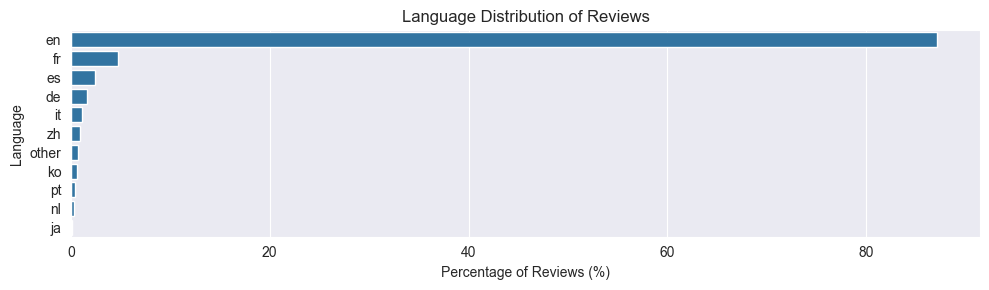

In [53]:
fig, ax = plt.subplots(figsize=(10, 3))

plot_data = reviews["lang"].value_counts().reset_index()
plot_data.loc[10:, 'lang'] = 'other'
plot_data = plot_data.groupby(["lang"]).sum().reset_index().sort_values('count', ascending=False)
total = plot_data["count"].sum()
plot_data["percentage"] = 100 * plot_data["count"] / total

sns.barplot(data=plot_data, x="percentage", y="lang",ax=ax)

ax.set_title("Language Distribution of Reviews")
ax.set_xlabel("Percentage of Reviews (%)")
ax.set_ylabel("Language")

plt.tight_layout()
plt.show()

In [54]:
plot_data

,lang,count,percentage
1,en,1294046,87.11
3,fr,69553,4.68
2,es,35564,2.39
0,de,24181,1.63
4,it,16905,1.14
10,zh,13766,0.93
8,other,10547,0.71
6,ko,8493,0.57
9,pt,6073,0.41
7,nl,4382,0.29


### Sentiment analysis

In [55]:
reviews_sentiment = pd.read_csv('data/reviews_sentiment.csv')
reviews_sentiment

,listing_id,id,date,reviewer_id,reviewer_name,comments,word_count,lang,lang_prob,sentiment_label,p_negative,p_neutral,p_positive,sentiment_score
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and...",49,en,0.99,positive,0.04,0.14,0.82,0.78
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...,46,en,0.97,positive,0.02,0.10,0.88,0.85
2,90700,337227,2011-06-27,311071,Miqua,it was all in all the perfect week!\r\nchilton...,84,en,0.99,positive,0.07,0.11,0.81,0.74
3,90700,378738,2011-07-17,224367,Prateek,"I'll start with the host, and then move on to ...",189,en,0.99,positive,0.20,0.30,0.50,0.30
4,90700,543840,2011-09-18,1115024,Jennifer,Great location. Plenty to do just steps outsid...,92,en,0.98,positive,0.05,0.10,0.85,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485592,39740287,559509688,2019-11-04,182032644,Isabel,"A very good stay, I would repeat for sure.",9,en,1.00,positive,0.02,0.05,0.93,0.91
1485593,22701498,558667202,2019-11-03,65955902,Shereen,"Set in a lovely development with onsite bar, c...",24,en,0.97,positive,0.01,0.09,0.90,0.89
1485594,38398365,552239161,2019-10-21,60436496,Chee Ling,(Website hidden by Airbnb) a.best owner and ge...,31,en,0.89,positive,0.03,0.11,0.85,0.82
1485595,38398365,559541617,2019-11-04,97684167,Carolyn,This flat is perfection! Everything you need i...,54,en,0.98,positive,0.04,0.07,0.89,0.86


In [56]:
reviews_sentiment['sentiment_label'].value_counts()

sentiment_label
positive    1356359
negative      94678
neutral       34560
Name: count, dtype: int64

In [57]:
reviews_sentiment['sentiment_label'].value_counts() / len(reviews_sentiment)

sentiment_label
positive                   0.91
negative                   0.06
neutral                    0.02
Name: count, dtype: float64

# End